To demonstrate the use of MaxWEnt with TensorFlow, we consider a one-dimensional regression problem where both the input space, $\mathcal{X}$, and the output space, $\mathcal{Y}$, lie in $\mathbb{R}$.

The input instances are drawn from $\mathcal{X} \subset \mathbb{R}$ according to a mixture of two Gaussians centered at $-0.5$ and $0.75$, each with a standard deviation of $0.1$. The outputs $y \in \mathcal{Y} \subset \mathbb{R}$ are generated according to the conditional distribution:


$$p(y|x) \sim f^*(x) + \epsilon$$


where $\epsilon \sim \mathcal{N}(0, 0.02)$ represents the “label” noise variable, and $f^*(x)$ is the “ground truth” function defined as:


$$f^*(x) = 0.3 \left(x + \sin(2 \pi x) + \sin(4 \pi x) \right)$$


## Setup

In [55]:
import matplotlib.pyplot as plt
from maxwent import regression_1d, plot_regression_1d

Below is an illustration of the problem. As shown, the training data are concentrated in two specific regions of the input space, leaving a significant portion of $\mathcal{X}$ out of distribution. In other words, a large area remains uncovered by the training data points, which poses challenges for learning $f$. 

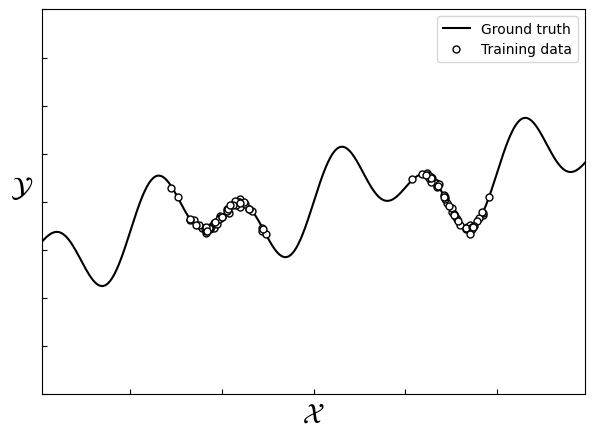

In [48]:
x_train, y_train, x_ood, y_ood = regression_1d()
ax = plot_regression_1d(x_train, y_train, x_ood, y_ood)
ax.legend(); plt.show()

## Base Network

Next, we define the neural network architecture. We use a fully connected network consisting of two dense layers with ReLU activation functions. Since this is a regression task, the output layer has a linear activation function.

In [49]:
import tensorflow as tf

base_net = tf.keras.Sequential()
base_net.add(tf.keras.layers.Input(shape=(1,)))
base_net.add(tf.keras.layers.Dense(100))
base_net.add(tf.keras.layers.ReLU())
base_net.add(tf.keras.layers.Dense(100))
base_net.add(tf.keras.layers.ReLU())
base_net.add(tf.keras.layers.Dense(1))
base_net.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,401 (40.63 KB)

 Trainable params: 10,401 (40.63 KB)

 Non-trainable params: 0 (0.00 B)

We specify the loss function and optimizer for training. In this case, we use the mean squared error (MSE) loss, which is a standard choice for regression problems.

In [50]:
base_net.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse")
base_net.fit(x_train, y_train, epochs=2500, verbose=0);

Now that the network has been trained on the training data, we visualize its predictions across the entire input space $\mathcal{X}$. The predicted values are shown in purple in the figure below.

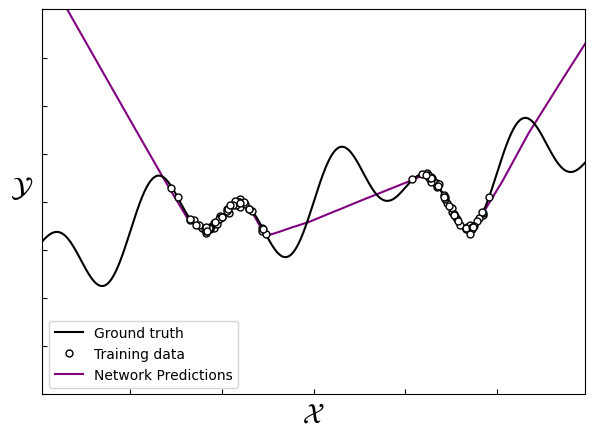

In [51]:
y_pred = base_net.predict(x_ood, verbose=0).ravel()

ax = plot_regression_1d(x_train, y_train, x_ood, y_ood)
ax.plot(x_ood, y_pred, c="purple", zorder=-1, label="Network Predictions")
ax.legend(); plt.show()

So far, nothing particularly groundbreaking—we have training data, we define a neural network, and we train it. As expected, the network fits the training data well.

However, outside the training domain, the network’s predictions deviate significantly from the ground truth. But let’s not be too harsh on the network—it is merely a local interpolator. With only the given training data, it has no way of inferring the full shape of the function $f$. Unless we explicitly enforce periodicity in the output, it would be quite unnatural for the network to recover the entire black curve. In fact, achieving such a result would suggest that we had used out-of-distribution data `x_ood, y_ood` instead of just the training data `x_train, y_train`.

It is important to emphasize that this is not a case of overfitting, where a model becomes overly specialized to the training data at the expense of generalization within the training distribution. In this scenario, if we were to sample new data points from the same distribution as the training set, the network would likely make accurate predictions. The issue here is different—it arises from encountering out-of-distribution data, where the model lacks sufficient knowledge to make reliable extrapolations beyond the training domain.

This highlights the necessity of incorporating an epistemic uncertainty quantifier. While we accept that the network cannot perfectly predict the ground truth beyond the training domain, we would prefer to have a range of plausible values rather than a single point estimate.

The most principled way to estimate epistemic uncertainty is by training multiple networks on the same dataset. Due to differences in initialization and the stochastic nature of gradient descent, an ensemble of networks will emerge. The diversity in their predictions serves as an indicator of epistemic uncertainty, helping us assess the confidence of our model in regions with little to no training data.

## Deep Ensemble

The following code builds an ensemble of five networks, each trained independently on the same training data.

In [ ]:
deep_ens = []

for _ in range(5):
    net = tf.keras.models.clone_model(base_net)
    net.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse")
    net.fit(x_train, y_train, epochs=2500, verbose=0);
    deep_ens.append(net)

The predictions over the input space $\mathcal{X}$ from the five networks are shown below.

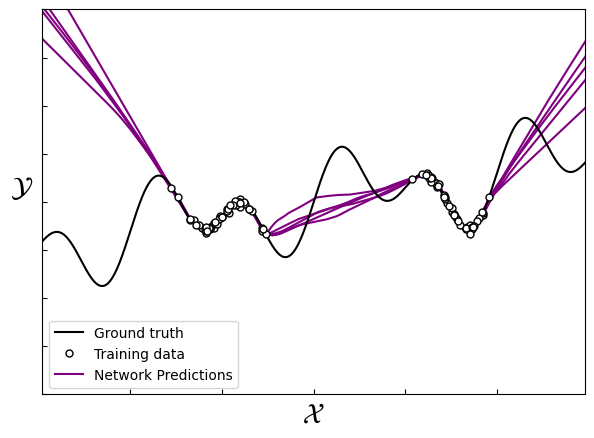

In [44]:
ax = plot_regression_1d(x_train, y_train, x_ood, y_ood)
for i in range(5):
    y_pred = net.predict(x_ood, batch_size=1000, verbose=0)
    ax.plot(x_ood, y_pred[i], c="purple", zorder=-1,
            label="Network Predictions" if i==0 else None)
ax.legend(); plt.show()

As we can observe, there is a noticeable discrepancy between the training domain and the out-of-distribution data. The predictions from the five networks remain quite close within the training data but diverge as we move further from it.

However, the diversity of the predictions is quite limited. In fact, the ground truth lies outside the range of outcomes provided by the ensemble, and the true function is smooth and continuous.

The issue here is that the ensemble of networks lacks sufficient diversity. Despite random initialization and training, the networks tend to converge to similar solutions.

This is where MaxWent comes into play. The goal of this approach is to maximize the diversity within the ensemble of networks, enhancing the ability to capture a broader range of potential predictions and uncertainties.

## Maximum Weight Entropy

To achieve this, we first introduce stochasticity into the network by using the set_maxwent_model function. This function replaces every Dense layer in the previous network with a DenseMaxWEnt layer.

In [19]:
from maxwent import set_maxwent_model

stoch_net = set_maxwent_model(base_net)
stoch_net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_mwe (DenseMaxWEnt)        │ (None, 100)            │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_mwe (ReLU)                │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_mwe (DenseMaxWEnt)      │ (None, 100)            │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1_mwe (ReLU)              │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2_mwe (DenseMaxWEnt)      │ (None, 1)              │        10,202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,803 (159.39 KB)

 Trainable params: 10,401 (40.63 KB)

 Non-trainable params: 30,402 (118.76 KB)

### Objective Function

The DenseMaxWEnt layer behaves similarly to a regular Dense layer, with one key difference: during each forward pass, the weights are sampled randomly from a distribution. Specifically, each weight $W_{ij}$ of the weight matrix $W$ is drawn according to the following distribution: 

$$ W_{ij} \sim \overline{W_{ij}} + \phi_{ij} \, z_{ij} $$

where  $z_{ij}$  follows a standard distribution, either uniform or normal with a mean of 0. Here, $\overline{W}$ represents the weight matrix of the base network (`base_net`), which has been pretrained on the training data and remains frozen (i.e., non-trainable). The only trainable parameters are the $\phi_{ij}$, which are the variances of the weight distributions. Note that the matrix $\phi$ has the same shape as $\overline{W}$ .

As we can see from the model summary, we now have ~40,000 parameters instead of ~10,000. However, only ~10,000 of these are trainable parameters: those being the variance parameters $\phi$. Among the non-trainable parameters are $\overline{W}$ (the frozen base network weights) and a matrix $V$, whose utility will be discussed later.

This stochastic network enables us to sample $z$ to generate different neural networks. The diversity of the resulting ensemble of networks is controlled by the variance parameters $\phi$. If $\phi = 0$, we simply sample the same network as `base_net`.

Conceptually, we can think of this process as sampling within a “ball” centered around the weights of our pretrained base network. To encourage diversity, we aim to maximize the variance parameters $\phi_{ij}$, but we must be cautious not to generate networks that fail to fit the data. In the extreme case where $\phi_{ij} \gg 1$ for any $i, j$, we risk sampling degenerate networks that do not perform well on the training data.

The `MaxWEnt` trainer below addresses this balance by optimizing the $\phi$ parameters with the following objective function:

$$ \mathbb{E}_z \left[ \sum_{(x, y) \in \mathcal{S}} \ell \left(y, h \left(x, \overline{W} + \phi \odot z \right) \right) \right] + \lambda \sum_{i, j} \log(\phi_{ij}^2) $$

Where:
- $\mathcal{S}$ is the training dataset.
- $\ell(. , .)$ is a loss function (the mean squared error in our case).
- $h(x , w )$ is the prediction of the neural network of weights $w$ for the input data $x \in \mathcal{X}$.
- $\odot$ is the element-wise product between two matrices.
- $z$ follows a standard multivariate distribution with independent components (uniform over [-1, 1] in this case)

The first term of the objective represents the average loss over the training data, which serves to constrain the variances $\phi_{ij}$ from growing too large in directions where perturbations to the weights would deteriorate the training performance. The second term is the entropy of the weight distribution, which encourages the $\phi_{ij}$ to grow as large as possible in directions where perturbations have minimal impact on the training loss. This dual objective ensures both diversity and fit to the training data.

### Training

In [20]:
from maxwent import MaxWEnt

mwe = MaxWEnt(stoch_net, lambda_=1.)

The parameter λ controls the trade-off between the two objectives. Increasing λ encourages greater weight diversity, but it should not be set too high, as this may excessively deteriorate the model’s accuracy on the training data. The number of training epochs also plays a role in this process. Typically, a larger λ can achieve higher weight diversity with fewer epochs, but beyond a certain point, the training loss may increase drastically. A practical heuristic is to increase both λ and the number of epochs as much as possible without causing the training loss to become unstable. Smaller values of λ result in a more gradual increase in weight entropy, which allows for greater flexibility in the final stages of training. However, this can also lead to a longer training time before a significant increase in weight entropy occurs.

In [21]:
mwe.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse")
mwe.fit(x_train, y_train, epochs=2500, verbose=0);

We now make predictions using the MaxWEnt model. It’s important to note that each time predict is called, a new set of weights is sampled, resulting in different predictions with every call. To obtain consistent predictions across multiple calls, you can use the `seed` argument. Using a fixed seed is good practice, as it ensures the same network is used for each batch during prediction. Without it, a new network is sampled for each batch, which can lead to discontinuous predictions along the input space $\mathcal{X}$.

### Inference

In [22]:
n_sample = 50

y_preds = [
    mwe.predict(x_ood, batch_size=32, seed=123+i)
    for i in range(n_sample)
]

Below are the results obtained. As observed, MaxWEnt enhances the diversity of neural networks, particularly at the left and right extremes of the input domain. However, the variability in predictions between networks remains low in the middle, between the two regions of the training domain. A possible explanation for this phenomenon is that the networks are constrained by information from both sides, reducing their capacity to generate diverse curves in the central region.

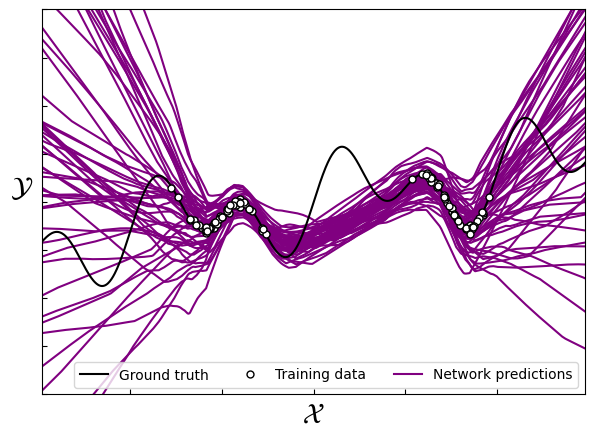

In [23]:
ax = plot_regression_1d(x_train, y_train, x_ood, y_ood)
for i in range(n_sample):
    ax.plot(x_ood, y_preds[i], c="purple", zorder=-1,
            label="Network predictions" if i==0 else None)
ax.legend(ncol=3); plt.show()

### Clipping

Now, let’s introduce the `clip` argument of the predict method. In some cases, one might want to reduce the diversity of the ensemble. While this could be achieved by adjusting the λ parameter or the number of training epochs, doing so can be cumbersome. Instead, the clip argument allows for a more convenient way to control diversity during inference by limiting the spread of the weight distribution.

Formally, given a clip parameter $C$, the weight distribution is modified as follows:


$$ W_{ij} \sim \overline{W_{ij}} + \min ( \phi_{ij} \, z_{ij}, C ) $$


This ensures that the sampled weights remain within a controlled range, effectively reducing the variance of predictions without requiring retraining. If `clip = None` no clipping is applied and if `clip = 0` the predictions are the same as the one of the base network.

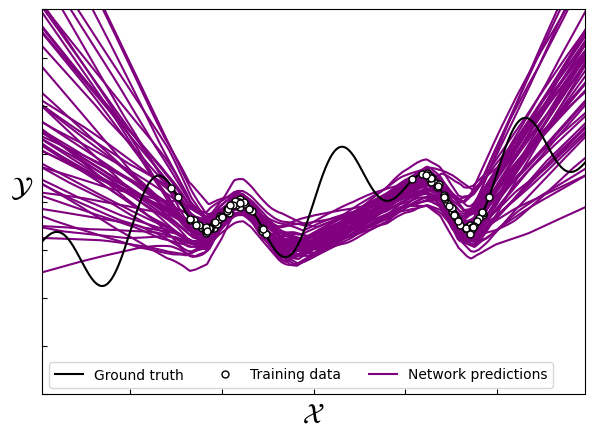

In [35]:
n_sample = 50

y_preds = [
    mwe.predict(x_ood, batch_size=1000, clip=1.)  # The clip argument is here !
    for _ in range(n_sample)
]

ax = plot_regression_1d(x_train, y_train, x_ood, y_ood)
for i in range(n_sample):
    ax.plot(x_ood, y_preds[i], c="purple", zorder=-1,
            label="Network predictions" if i==0 else None)
ax.legend(ncol=3); plt.show()

### Uncertainty Quantification

MaxWEnt provides two built-in methods, predict_mean and predict_std, which directly compute the mean and standard deviation of predictions across multiple sampled networks. These methods are particularly useful for constructing confidence intervals in regression tasks.

It’s important to note that the clip and n_sample parameters serve different purposes in these two methods. For predict_mean, it is recommended to use a small clip value (or even 0) since excessive diversity can degrade accuracy. By default, clip is set to 0, making the model deterministic, and n_sample is set to 1, as there is no need to sample multiple networks when there is no weight variance.

On the other hand, when computing the standard deviation using predict_std, the goal is to maximize diversity. Therefore, clip is set to None, meaning no clipping is applied. The n_sample parameter is set to 50, ensuring predictions are drawn from 50 different network samples. While increasing n_sample generally improves the reliability of uncertainty estimates, it also increases computational cost.

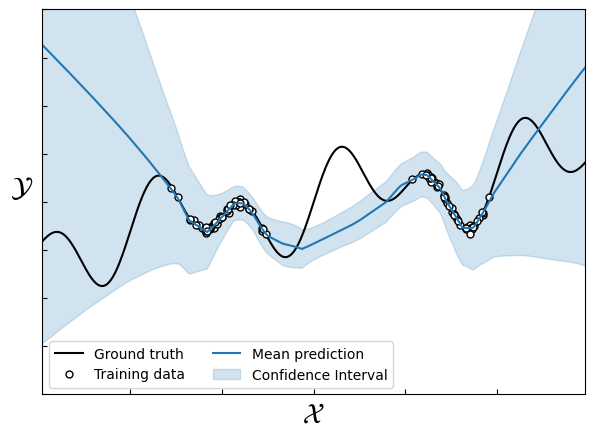

In [36]:
y_pred_mean = mwe.predict_mean(x_ood, batch_size=1000, clip=0., n_sample=1).ravel()
y_pred_std = mwe.predict_std(x_ood, batch_size=1000, clip=None, n_sample=50).ravel()

ax = plot_regression_1d(x_train, y_train, x_ood, y_ood)
ax.plot(x_ood.ravel(), y_pred_mean, c="C0", label='Mean prediction')
ax.fill_between(x_ood.ravel(),
                y_pred_mean - 2 * y_pred_std,
                y_pred_mean + 2 * y_pred_std, color='C0', alpha=0.2,
                label='Confidence Interval')
ax.legend(ncol=2); plt.show()

### SVD Parameterization

In this section of the tutorial, we introduce the SVD parameterization and examine its impact on model predictions. Specifically, we leverage the  V  matrix introduced earlier. Each DenseMaxWEnt layer includes a non-trainable  V  matrix, which serves to introduce correlations between weight components. When applied, the weight distribution follows:


$$ W \sim \overline{W} + V ( \phi \odot z ) $$


If  V  is the identity matrix, the formulation remains unchanged from the previous approach, meaning no correlation is introduced between weight components. A key advantage of the  V  matrix is that it does not require training alongside  \phi . Instead, it can be precomputed using the fit_svd method before training. This is achieved by performing a forward pass of the training data through the base network, after which  V  is stored as a fixed, non-trainable parameter.

In [15]:
stoch_net = set_maxwent_model(base_net)
mwe = MaxWEnt(stoch_net, lambda_=1.)

mwe.fit_svd(x_train)

As you can see, the setup remains the same as before, with the only difference being the intermediate step of calling fit_svd.

In [16]:
mwe.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse")
mwe.fit(x_train, y_train, epochs=2500, verbose=0);

When analyzing the results, we observe that the epistemic uncertainty is now well estimated in the region between the two parts of the training domain.

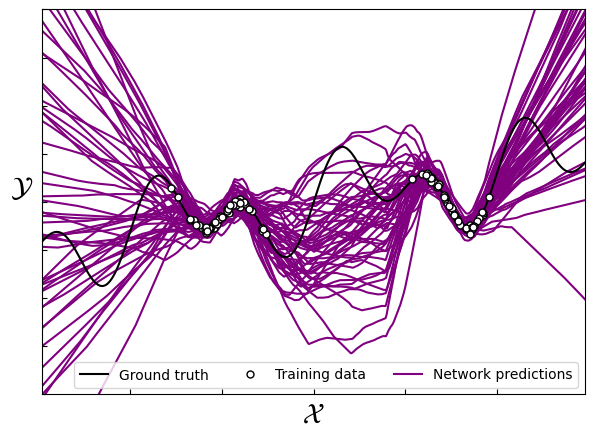

In [17]:
n_sample = 50

y_preds = [
    mwe.predict(x_ood, batch_size=1000)
    for _ in range(n_sample)
]

ax = plot_regression_1d(x_train, y_train, x_ood, y_ood)
for i in range(n_sample):
    ax.plot(x_ood, y_preds[i], c="purple", zorder=-1,
            label="Network predictions" if i==0 else None)
ax.legend(ncol=3); plt.show()

 The confidence interval effectively captures the ground truth, providing a reasonable expectation of uncertainty in this problem.

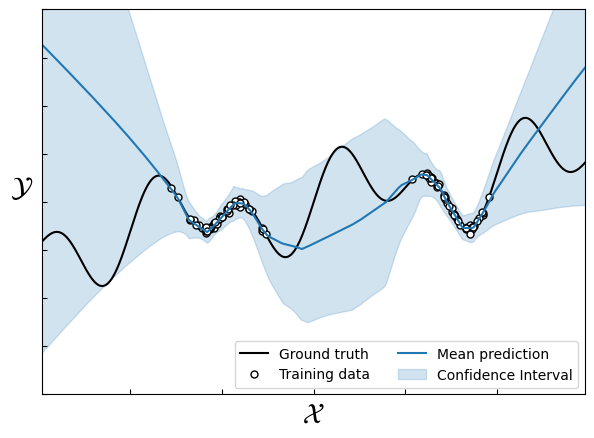

In [18]:
y_pred_mean = mwe.predict_mean(x_ood, batch_size=1000, clip=0., n_sample=1).ravel()
y_pred_std = mwe.predict_std(x_ood, batch_size=1000, clip=None, n_sample=50).ravel()

ax = plot_regression_1d(x_train, y_train, x_ood, y_ood)
ax.plot(x_ood.ravel(), y_pred_mean, c="C0", label='Mean prediction')
ax.fill_between(x_ood.ravel(),
                y_pred_mean - 2 * y_pred_std,
                y_pred_mean + 2 * y_pred_std, color='C0', alpha=0.2,
                label='Confidence Interval')
ax.legend(ncol=2); plt.show()

It is worth noting that for this simple 1D case, a distance-based method such as Gaussian processes—where uncertainty is derived from the distance to the training data—could have yielded similar or even better results. However, the real challenge here was to estimate uncertainty through a distribution over the neural network’s weights. The deep ensemble approach is particularly useful for high-dimensional problems, where defining a meaningful distance metric is not straightforward.